In [1]:
import cv2
import glob
import imageio
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from heapq import nlargest,nsmallest
from itertools import combinations
from matplotlib.patches import Circle
from PIL import Image, ImageDraw
from scipy import ndimage,signal,misc,linalg
from skimage import measure
from skimage.color import rgb2gray
from sklearn import linear_model as lm
from shutil import copyfile

In [2]:
kernelPath = 'circle_r24.png'  # Relative path to the kernal image (white circle on a black background)
imagePath = 'images/individual'   # Relative path to the images folder
savePath = 'html/example'   # Relative path to the save location

k = 0.05    # Parameter for Harris detection
threshold = .95 #.80 #.85 
preconvthreshold = 232

# Process kernel
kernel = imageio.imread(kernelPath).astype(float)  # Save the image to an array
kernel = kernel[:,:,:3].sum(axis=2)/3 if len(kernel.shape)==3 else kernel  # allow for RGB or RGBA image
kernel = kernel-kernel.mean()  # Normalize kernels (so avg color is 0)

# Process Image files
imagefiles = sorted(glob.glob(imagePath+'/*.jpg'))  # Select all JPG files in the specified folder

In [3]:
def convPoints(img, kernel, viewConvolution=False):
    '''Returns an array of all points which exceed a certain threshold on the image after convolution.
    
    Parameters: 
    img (np.array): Image being convolved
    kernel (np.array): Kernel being used for convolution
    viewConvolution (boolean): Whether to display an image of the convolution
  
    Returns: 
    np.array: Array of points exceeding covolution threshold '''
    
    global threshold

    a = signal.fftconvolve(img, kernel, mode='same')  # Convolution
    # If convolution isn't picking up any good matches, assume there's no yellowjackets
    if (np.max(a)-np.min(a) < 5000000):
        return ([])

    # Look at convolution
    if viewConvolution:
        plt.imshow(a,cmap='gist_ncar')#'gray')
        plt.colorbar()
        plt.show()

    # Thresholding: All pixels above threshold get set to 1
    a = (a - a.min()) / a.max()# Normalize to [0,1]
    above = a>threshold 
    a = np.zeros(a.shape,dtype=int)
    a[above] = 1

    # Find connected components of thresholded image
    #labelarray = measure.label(a, neighbors=8, background=0)
    labelarray = measure.label(a, connectivity=2, background=0)
    labels = np.unique(labelarray)

    # Find centroid of each connected component
    points = []
    for label in labels[1:]:
        y,x = np.where(labelarray==label)
        points.append((x,y))

    return (points)

In [4]:
def detectAndCrop(img, kernel):
    '''Crops image down to rectangular image centered at centroid
    
    Parameters: 
    img (np.array): Image being cropped
    kernel (np.array): Kernel being used for convolution
  
    Returns: 
    np.array: Image cropped down to area around yellowjacket '''
    
    rgbArray = np.zeros((img.shape[0],img.shape[1],3), 'uint8')
    rgbArray[..., 0] = img
    rgbArray[..., 1] = img
    rgbArray[..., 2] = img
    imgd = Image.fromarray(rgbArray)
    unedited = imgd.copy()
    draw = ImageDraw.Draw(imgd)
    processedImgs = []
    
    yellowjackets = convPoints(img, kernel) # Get an array of x,y coordinates for each detected yellowjacket
    
    r = 3 # Radius of dots
    scaleUpPercent = 300 # What % larger than the yellowjacket should the selected region be?
    
    for points in yellowjackets:
        
        # Draw on points where convolution detected yellowjacket shape
        #for i in range(len(points[0])):
        #    draw.point ((points[0][i], points[1][i]), fill=(0,255,0))
            
        # Find and draw dots on yellowjacket centorids
        centroid = (points[0].mean(), points[1].mean())
        ix, iy = int(centroid[0]+0.5), int(centroid[1]+0.5)
        #draw.ellipse((ix-r, iy-r, ix+r, iy+r), fill=(0,128,0), outline = None)
        
        # Crop image down to a rectangular region centered around each yellowjacket
        rect = ((points[0].min(),points[1].min()),(points[0].max(),points[1].max()))
        width = rect[1][0]-rect[0][0]
        height = rect[1][1]-rect[0][1]
        x1 = int(ix - (width/2) - .005 * scaleUpPercent * width)
        x2 = int(ix + (width/2) + .005 * scaleUpPercent * width)
        y1 = int(iy - (height/2) - .005 * scaleUpPercent * height)
        y2 = int(iy + (height/2) + .005 * scaleUpPercent * height)
        #draw.rectangle([x1 y1 x2 y2], outline='red')
        processedImgs.append(imgd.crop([x1,y1,x2,y2]))
                
    return(processedImgs)

In [5]:
def lookAtCorners(img, maxCorners=50):
    '''Run this to look at the raw image with corners detected on it
    
    Parameters: 
    img (np.array): Image being analyzed
    maxCorners (int): Maximum # of corners to detect
  
    Returns: 
    np.array: Image with detected corners overlayed '''
    
    # Use corner detection algorithm to get any corners in the image
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY) 
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=maxCorners, qualityLevel=0.1, minDistance=1,
                                      useHarrisDetector=False)
    
    # Draw the corners onto the image as small white points
    cornerImg = image.copy()
    draw = ImageDraw.Draw(cornerImg)
    draw.point(corners)
    
    
    return(cornerImg)

In [6]:
# Vocabulary:
# Tip = End of an antenna
# Root = Start of an antenna (where it meets the head)
# Centroid = Best approximation for middle of yellowjacket
# Stinger = End of the stinger on the back of a yellowjacket

def getTipScore(img, listOfCornerPairs):
    ''' Scores the likelihood of each pair of points in listOfCorners being an antenna tip.
    
   Score Formula = (C>15deg)*(C<120deg)*[D + (1-B) + (1-R)]
   where:
    C = Centroid Angle of triangle drawn between centroid and the pair of "test" points.
    D = Avg Distance from test points to centroid (normalized w.r.t farthest points)
    B = Avg Brightness in neighborhood near each test point (normalized w.r.t brightest points)
    R = Relative difference in distances: |distAtoCentroid - distBtoCentroid|/(distAtoCentroid + distBtoCentroid) 
    
    Parameters: 
    img (np.array): Image being analyzed
    listOfCornerPairs (np.array): Array containing all possible pairs of detected corners
  
    Returns: 
    np.array: List of scores describing how likely it is that a given pair of points are antenna tips'''
    
    scoreList = np.zeros((len(listOfCornerPairs),4))
    centroid = (np.shape(img)[1]/2,np.shape(img)[0]/2) # (width/2, height/2)
    
    for i,pair in enumerate(listOfCornerPairs):
        
        # Turn corners pair into 2 integer corner tuples
        tipA, tipB = pair
        tipA = (int(tipA[0]),int(tipA[1]))
        tipB = (int(tipB[0]),int(tipB[1]))
        
        # Strategy: Create a triangle using A, B, and the origin
        dA = np.linalg.norm(tuple(map(lambda a, b: a - b, tipA, centroid)))
        dB = np.linalg.norm(tuple(map(lambda a, b: a - b, tipB, centroid)))
        dAB = np.linalg.norm(tuple(map(lambda a, b: a - b, tipA, tipB)))
            
        # Use law of cosines on center angle of the triangle (only continue if angle in [15deg, 120deg] range)
        angle = np.arccos((dAB**2 - dA**2 - dB**2)/(-2*dA*dB))
        if not (angle >= 2*np.pi/24 and angle <= 2*np.pi/3):
            scoreList[i,0] = 0  # C=0
            continue
        scoreList[i,0] = 1  # C=1
        
        # Evaluate Average distance from centroid (Want LARGE distances)
        scoreList[i,1] = .5*(dA+dB)
        
        # Evaluate Average nearby brightness (Want LOW brightness)
        maxBright = np.max(img)
        
        brightA = np.mean(img[tipA[1]-3:tipA[1]+3, tipA[0]-3:tipA[0]+3]) / maxBright
        brightB = np.mean(img[tipB[1]-3:tipB[1]+3, tipB[0]-3:tipB[0]+3]) / maxBright
        
        scoreList[i,2] = .5*(brightA+brightB)
                
        # Get relative distance difference and multiply
        relDist = np.abs(dA-dB)/(dA+dB)
        scoreList[i,3] = relDist
    
    scoreList[:,1] /= np.max(scoreList[:,1])  # Normalize distances
    scoreList[:,2] /= np.max(scoreList[:,2])  # Normalize brightnesses
    
    #print(scoreList)
    
    # Compute formula
    finalScoreList = scoreList[:,0] * (0*scoreList[:,1] + 0*(1-scoreList[:,2]) + (1-scoreList[:,3]))
    return finalScoreList


def getRootScore(img, listOfCornerPairs, tips):
    ''' Scores the likelihood of each pair of points in listOfCorners being an antenna tip.
    
   Score Formula = (C<60deg)*[(1-D) + (1-B) + (1-R)]
   where:
    C = Centroid Angle of triangle drawn between centroid and the pair of "test" points
    D = Avg Distance from test points to each tip (normalized w.r.t farthest points)
    B = 2*|AvgBrightness - 0.5| using neighborhood brightness near each test point
    R = Relative difference in distances: |distAtoCentroid - distBtoCentroid|/(distAtoCentroid + distBtoCentroid) 
    
    Parameters: 
    img (np.array): Image being analyzed
    listOfCornerPairs (np.array): Array containing all possible pairs of detected corners
    tips (np.array): Array containing the pair of detected antenna tips
  
    Returns: 
    np.array: List of scores describing how likely it is that a given pair of points are antenna tips'''
    
    
    scoreList = np.zeros((len(listOfCornerPairs),4))
    centroid = (np.shape(img)[1]/2,np.shape(img)[0]/2)  # (width/2, height/2)
    
    tipA, tipB = tips
    
    for i,pair in enumerate(listOfCornerPairs):
        
        # Turn corners pair into 2 integer corner tuples
        rootA, rootB = pair
        rootA = (int(rootA[0]),int(rootA[1]))
        rootB = (int(rootB[0]),int(rootB[1]))
        
        # Score 0 if "test" root is the same as any of the tips
        if (tipA == rootA) or (tipA == rootB) or (tipB == rootA) or (tipB == rootB):
            scoreList[i,0] = 0  # C=0
            continue
        
        # Strategy: Create a triangle using A, B, and the origin
        dA = np.linalg.norm(tuple(map(lambda a, b: a - b, rootA, centroid)))
        dB = np.linalg.norm(tuple(map(lambda a, b: a - b, rootB, centroid)))
        dAB = np.linalg.norm(tuple(map(lambda a, b: a - b, rootA, rootB)))
            
        # Use law of cosines on center angle of the triangle (only continue if angle in [0deg, 60deg] range)
        angle = np.arccos((dAB**2 - dA**2 - dB**2)/(-2*dA*dB))
        if not (angle <= 2*np.pi/6):
            scoreList[i,0] = 0  # C=0
            continue
        scoreList[i,0] = 1  # C=1
        
        # Evaluate Average distance from roots to each tip (Want SMALL distances)
        dRootAToTipA = np.linalg.norm(tuple(map(lambda a, b: a - b, rootA, tipA)))
        dRootBToTipB = np.linalg.norm(tuple(map(lambda a, b: a - b, rootB, tipB)))
        scoreList[i,1] = .5*(dRootAToTipA + dRootBToTipB)
        
        
        # Evaluate Average nearby brightness (Want LOW brightness)
        maxBright = np.max(img)
        brightA = np.mean(img[rootA[1]-3:rootA[1]+3, rootA[0]-3:rootA[0]+3]) / maxBright
        brightB = np.mean(img[rootB[1]-3:rootB[1]+3, rootB[0]-3:rootB[0]+3]) / maxBright
        scoreList[i,2] = .5*(brightA+brightB)
                
        # Get relative distance difference and multiply
        relDist = np.abs(dA-dB)/(dA+dB)
        scoreList[i,3] = relDist
    
    scoreList[:,1] /= np.max(scoreList[:,1])  # Normalize distances
    scoreList[:,2] /= np.max(scoreList[:,2])  # Normalize brightnesses
    scoreList[:,2] = 2 * np.abs(scoreList[:,2] - 0.5)  # Interested in how close brightness is to 0.5
    
    #print(scoreList)
    
    # Compute formula
    finalScoreList = scoreList[:,0] * ((1-scoreList[:,1]) + (1-scoreList[:,2]) + (1-scoreList[:,3]))
    #finalScoreList = scoreList[:,0] * (1-scoreList[:,1]) * (1-scoreList[:,2]) + (1-scoreList[:,3])]
    
    return finalScoreList


def getStingerScore(img, listOfCorners, roots):
    ''' Scores the likelihood of each point in listOfCorners being an antenna stinger.
    k
   Score Formula = (C1>90deg)*(C2>90deg)*[D + (1-B) + (1-R)]
   where:
    C1 = Central Angle of triangle drawn between centroid, rootA, and pointer
    C2 = Central Angle of triangle drawn between centroid, rootB, and pointer
    D = Distance from test point to centroid (normalized w.r.t farthest point)
    B = (3/2)*|AvgBrightness - 1/3| using neighborhood brightness near the test point
    R = Relative difference in distances: |pointerToRootA - pointerToRootB|/(pointerToRootA + pointerToRootB)
    
    Parameters: 
    img (np.array): Image being analyzed
    listOfCorners (np.array): Array containing all possible stinger points
    roots (np.array): Array containing the pair of detected antenna tips
  
    Returns: 
    np.array: List of scores describing how likely it is that a given pair of points are antenna tipsScores the likelihood of each pair of points in an inputted list being an antenna tip.
    '''
    
    scoreList = np.zeros((len(listOfCorners),4))
    centroid = (np.shape(img)[1]/2,np.shape(img)[0]/2) # (width/2, height/2)
    
    rootA, rootB = roots
    
    for i,point in enumerate(listOfCorners):
        
        point = (int(point[0]), int(point[1]))
        
        # Score 0 if "test" stinger is the same as any of the roots
        if (point == rootA) or (point == rootB):
            scoreList[i,0] = 0  # C=0
            continue
        
        # Strategy: Create a triangle using Point, Root A, and the origin
        dRootA = np.linalg.norm(tuple(map(lambda a, b: a - b, rootA, centroid)))
        dPoint = np.linalg.norm(tuple(map(lambda a, b: a - b, point, centroid)))
        dRootAPoint = np.linalg.norm(tuple(map(lambda a, b: a - b, point, rootA)))
            
        # Use law of cosines on center angle of the triangle (only continue if angle > 90 deg)
        angle = np.arccos((dRootAPoint**2 - dRootA**2 - dPoint**2)/(-2*dRootA*dPoint))
        if not (angle >= np.pi/2):
            scoreList[i,0] = 0  # C1=0
            continue
        scoreList[i,0] = 1  # C1=1
        
        # Strategy: Create a triangle using Point, Root B, and the origin
        dRootB = np.linalg.norm(tuple(map(lambda a, b: a - b, rootB, centroid)))
        dRootBPoint = np.linalg.norm(tuple(map(lambda a, b: a - b, point, rootB)))
            
        # Use law of cosines on center angle of the triangle (only continue if angle > 90 deg)
        angle = np.arccos((dRootBPoint**2 - dRootB**2 - dPoint**2)/(-2*dRootB*dPoint))
        if not (angle >= np.pi/2):
            scoreList[i,0] = 0  # C2=0
            continue
        scoreList[i,0] = 1  # C2=1
        
        # Evaluate Distance from centroid (Want LARGE distance)
        scoreList[i,1] = dPoint
        
        # Evaluate Average nearby brightness (Want LOW brightness)
        maxBright = np.max(img)
        bRadius = 6
        brightness = np.mean(img[point[1]-bRadius:point[1]+bRadius, point[0]-bRadius:point[0]+bRadius]) / maxBright
        scoreList[i,2] = brightness
                
        # Get relative distance difference from pointer to each root
        relDist = np.abs(dRootAPoint-dRootBPoint)/(dRootAPoint+dRootBPoint)
        scoreList[i,3] = relDist
    
    scoreList[:,1] /= np.max(scoreList[:,1])  # Normalize distances
    scoreList[:,2] /= np.max(scoreList[:,2])  # Normalize brightnesses
    scoreList[:,2] = (3/2) * np.abs(scoreList[:,2] - (1/3))  # Interested in how close brightness is to 1/3
    
    #print(scoreList)
    
    # Compute formula
    finalScoreList = scoreList[:,0] * (scoreList[:,1] + (1-scoreList[:,2]) + (1-scoreList[:,3]))
    
    return finalScoreList

In [7]:
def specialCorners(img):
    '''Try to identify special points on a given image: antenna tips, antenna roots, and stinger'''
    
    # Use corner detection algorithm to get any corners in the image
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY) 
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=40, qualityLevel=0.1, minDistance=1,
                                      useHarrisDetector=False)

    # Draw the corners onto the image as small white points
    cornerImg = img.copy()
    draw = ImageDraw.Draw(cornerImg)
    draw.point(corners)
    
    cornerPairs = []
    for pair in combinations(corners[:,0], 2):
        cornerPairs.append(pair)
    tipScores = getTipScore(gray, cornerPairs)
    
    tipA, tipB = cornerPairs[np.argmax(tipScores)]
    tipA = (int(tipA[0]),int(tipA[1]))
    tipB = (int(tipB[0]),int(tipB[1]))
    
    print ('Best tips at:',tipA,'and',tipB,'with score', round(np.max(tipScores), 2))
    
    r=1
    draw.ellipse((tipA[0]-r, tipA[1]-r, tipA[0]+r, tipA[1]+r), fill='pink', outline = None)
    draw.ellipse((tipB[0]-r, tipB[1]-r, tipB[0]+r, tipB[1]+r), fill='pink', outline = None)

    # Once antenna tips located, try to find antenna "roots"
    distancesFromTipA = {}
    distancesFromTipB = {}
    for c in corners[:,0]:
        if (tuple(c) == tipA) or (tuple(c) == tipB): continue  # Skip the tips
        distancesFromTipA[tuple(c)] = np.linalg.norm(c-np.array(tipA))
        distancesFromTipB[tuple(c)] = np.linalg.norm(c-np.array(tipB))
    # Take the top 5 closest points to each tip
    top5A = nsmallest(5, distancesFromTipA, key = distancesFromTipA.get)
    top5B = nsmallest(5, distancesFromTipB, key = distancesFromTipB.get)

    rootGuesses = []
    for k in range(5):
        rootA = top5A[k]
        for l in range(5):
            rootB = top5B[l]
            
            r=1
            #draw.ellipse((rootA[0]-r, rootA[1]-r, rootA[0]+r, rootA[1]+r), fill='cyan', outline = None)
            #draw.ellipse((rootB[0]-r, rootB[1]-r, rootB[0]+r, rootB[1]+r), fill='magenta', outline = None)
            rootGuesses.append([rootA, rootB])
            
    rootScores = getRootScore(gray, rootGuesses, (tipA,tipB))
    
    rootA, rootB = rootGuesses[np.argmax(rootScores)]
    rootA = (int(rootA[0]),int(rootA[1]))
    rootB = (int(rootB[0]),int(rootB[1]))
    
    print ('Best roots at:',rootA,'and',rootB,'with score', round(np.max(rootScores), 2))
    
    r=1
    draw.ellipse((rootA[0]-r, rootA[1]-r, rootA[0]+r, rootA[1]+r), fill='red', outline = None)
    draw.ellipse((rootB[0]-r, rootB[1]-r, rootB[0]+r, rootB[1]+r), fill='red', outline = None)


    stingerScores = getStingerScore(gray, corners[:,0], (rootA,rootB))
    
    maxval = np.argmax(stingerScores)
    stinger = corners[:,0][maxval]
    stinger = (int(stinger[0]),int(stinger[1]))

    print ('Best stinger at:',stinger,'with score', round(np.max(stingerScores), 2))
    
    r=1
    draw.ellipse((stinger[0]-r, stinger[1]-r, stinger[0]+r, stinger[1]+r), fill='orange', outline = None)

    # Find and draw dots on yellowjacket centorids
    centroid = (np.shape(img)[1]/2,np.shape(img)[0]/2) # (width/2, height/2)
    ix, iy = int(centroid[0]+0.5), int(centroid[1]+0.5)
    r=1
    draw.ellipse((ix-r, iy-r, ix+r, iy+r), fill=(0,128,0), outline = None)

    specialPoints = {
    'tips': (tipA, tipB),
    'roots': (rootA, rootB),
    'stinger': stinger
    }
    
    return(cornerImg, specialPoints)

Detected 2 yellowjackets in Image 0
Best tips at: (68, 77) and (65, 86) with score 1.0
Best roots at: (64, 75) and (67, 82) with score 2.11
Best stinger at: (110, 81) with score 2.74


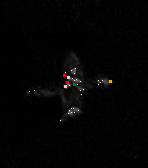

Best tips at: (64, 65) and (76, 65) with score 1.0
Best roots at: (70, 59) and (74, 59) with score 1.93
Best stinger at: (81, 99) with score 2.88


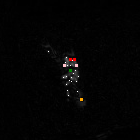

Detected 1 yellowjackets in Image 1
Best tips at: (67, 72) and (72, 70) with score 1.0
Best roots at: (67, 70) and (71, 72) with score 2.33
Best stinger at: (68, 91) with score 2.47


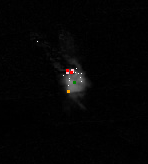

Detected 1 yellowjackets in Image 2
Best tips at: (62, 73) and (71, 70) with score 1.0
Best roots at: (59, 76) and (66, 69) with score 2.39
Best stinger at: (67, 119) with score 2.52


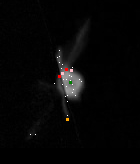

Detected 0 yellowjackets in Image 3
Detected 1 yellowjackets in Image 4
Best tips at: (50, 59) and (62, 59) with score 1.0
Best roots at: (65, 59) and (65, 59) with score 2.51
Best stinger at: (52, 119) with score 2.82


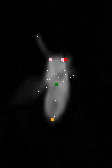

Detected 1 yellowjackets in Image 5
Best tips at: (85, 92) and (51, 110) with score 1.0
Best roots at: (87, 98) and (67, 116) with score 2.09
Best stinger at: (70, 61) with score 2.76


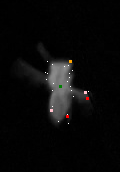

Detected 1 yellowjackets in Image 6
Best tips at: (52, 62) and (65, 61) with score 0.97
Best roots at: (64, 58) and (64, 58) with score 2.76
Best stinger at: (55, 118) with score 2.7


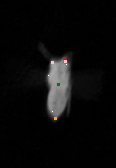

Detected 1 yellowjackets in Image 7
Best tips at: (46, 66) and (57, 64) with score 0.98
Best roots at: (60, 61) and (60, 61) with score 2.16
Best stinger at: (56, 125) with score 2.81


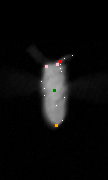

Detected 0 yellowjackets in Image 8
Detected 0 yellowjackets in Image 9
Detected 1 yellowjackets in Image 10
Best tips at: (94, 98) and (84, 90) with score 1.0
Best roots at: (96, 108) and (79, 91) with score 2.18
Best stinger at: (144, 56) with score 2.86


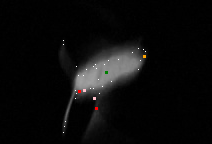

Detected 1 yellowjackets in Image 11
Best tips at: (77, 83) and (87, 73) with score 1.0
Best roots at: (81, 87) and (91, 78) with score 1.64
Best stinger at: (53, 18) with score 2.58


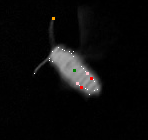

Detected 1 yellowjackets in Image 12
Best tips at: (48, 64) and (56, 54) with score 0.99
Best roots at: (52, 54) and (52, 54) with score 2.2
Best stinger at: (80, 97) with score 2.55


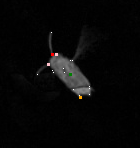

Detected 1 yellowjackets in Image 13
Best tips at: (75, 69) and (77, 77) with score 1.0
Best roots at: (73, 73) and (73, 73) with score 1.15
Best stinger at: (54, 108) with score 2.74


<ipython-input-6-5d6110943c3e>:40: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos((dAB**2 - dA**2 - dB**2)/(-2*dA*dB))
<ipython-input-6-5d6110943c3e>:113: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos((dAB**2 - dA**2 - dB**2)/(-2*dA*dB))


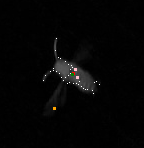

Detected 2 yellowjackets in Image 14
Best tips at: (92, 76) and (93, 69) with score 1.0
Best roots at: (94, 76) and (99, 64) with score 2.39
Best stinger at: (50, 42) with score 2.75


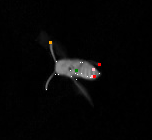

Best tips at: (75, 34) and (66, 33) with score 0.98
Best roots at: (76, 41) and (76, 41) with score 2.16
Best stinger at: (69, 62) with score 2.48


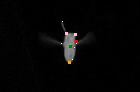

Detected 1 yellowjackets in Image 15
Best tips at: (60, 96) and (67, 98) with score 1.0
Best roots at: (60, 102) and (60, 102) with score 2.08
Best stinger at: (82, 54) with score 2.93


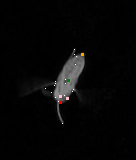

Detected 1 yellowjackets in Image 16
Best tips at: (65, 141) and (72, 141) with score 0.98
Best roots at: (70, 142) and (70, 142) with score 2.6
Best stinger at: (77, 76) with score 2.81


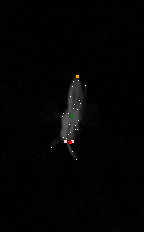

Detected 1 yellowjackets in Image 17
Best tips at: (77, 56) and (89, 70) with score 1.0
Best roots at: (81, 62) and (91, 65) with score 2.19
Best stinger at: (57, 114) with score 2.6


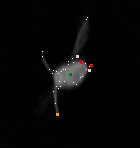

Detected 1 yellowjackets in Image 18
Best tips at: (63, 58) and (54, 67) with score 1.0
Best roots at: (60, 55) and (50, 65) with score 2.58
Best stinger at: (97, 94) with score 2.91


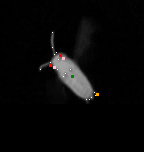

Detected 1 yellowjackets in Image 19
Best tips at: (51, 63) and (56, 58) with score 0.99
Best roots at: (49, 59) and (52, 54) with score 2.38
Best stinger at: (87, 102) with score 2.62


<ipython-input-6-5d6110943c3e>:188: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos((dRootAPoint**2 - dRootA**2 - dPoint**2)/(-2*dRootA*dPoint))


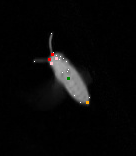

Detected 1 yellowjackets in Image 20
Best tips at: (53, 58) and (47, 63) with score 1.0
Best roots at: (55, 56) and (55, 56) with score 2.6
Best stinger at: (85, 102) with score 2.91


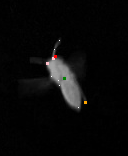

Detected 1 yellowjackets in Image 21
Best tips at: (40, 85) and (68, 60) with score 0.99
Best roots at: (54, 82) and (64, 68) with score 2.3
Best stinger at: (94, 119) with score 2.88


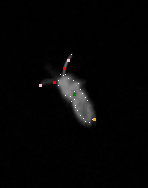

Detected 1 yellowjackets in Image 22
Best tips at: (76, 57) and (78, 72) with score 0.99
Best roots at: (79, 56) and (83, 72) with score 2.51
Best stinger at: (134, 56) with score 2.97


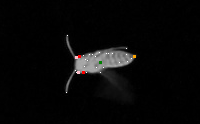

Detected 1 yellowjackets in Image 23
Best tips at: (46, 65) and (52, 49) with score 0.97
Best roots at: (50, 53) and (50, 53) with score 2.18
Best stinger at: (92, 66) with score 2.76


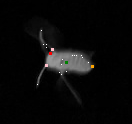

Detected 2 yellowjackets in Image 24
Best tips at: (74, 87) and (79, 84) with score 0.99
Best roots at: (77, 89) and (83, 82) with score 1.98
Best stinger at: (62, 30) with score 2.55


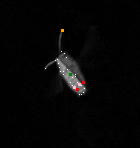

Best tips at: (60, 59) and (63, 62) with score 1.0
Best roots at: (63, 60) and (63, 60) with score 2.26
Best stinger at: (61, 30) with score 2.62


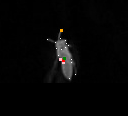

Detected 2 yellowjackets in Image 25
Best tips at: (60, 63) and (86, 61) with score 1.0
Best roots at: (60, 61) and (71, 58) with score 2.01
Best stinger at: (89, 97) with score 2.9


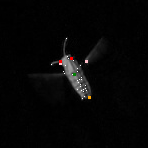

Best tips at: (66, 46) and (57, 48) with score 1.0
Best roots at: (63, 43) and (54, 49) with score 2.25
Best stinger at: (75, 77) with score 2.92


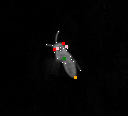

Detected 2 yellowjackets in Image 26
Best tips at: (65, 83) and (71, 75) with score 1.0
Best roots at: (71, 80) and (71, 80) with score 1.12
Best stinger at: (84, 105) with score 2.8


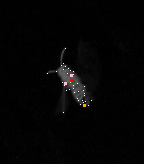

Best tips at: (80, 76) and (67, 79) with score 1.0
Best roots at: (77, 74) and (67, 76) with score 2.24
Best stinger at: (69, 105) with score 2.32


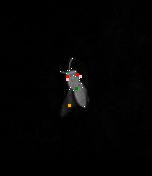

Detected 2 yellowjackets in Image 27
Best tips at: (44, 49) and (37, 59) with score 1.0
Best roots at: (40, 48) and (37, 61) with score 2.39
Best stinger at: (73, 70) with score 2.85


<ipython-input-6-5d6110943c3e>:40: RuntimeWarning: invalid value encountered in double_scalars
  angle = np.arccos((dAB**2 - dA**2 - dB**2)/(-2*dA*dB))
<ipython-input-6-5d6110943c3e>:188: RuntimeWarning: invalid value encountered in double_scalars
  angle = np.arccos((dRootAPoint**2 - dRootA**2 - dPoint**2)/(-2*dRootA*dPoint))


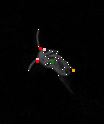

Best tips at: (70, 69) and (86, 69) with score 1.0
Best roots at: (73, 57) and (82, 63) with score 1.76
Best stinger at: (78, 95) with score 2.7


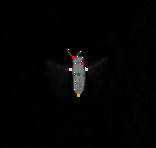

Detected 2 yellowjackets in Image 28
Best tips at: (83, 63) and (89, 63) with score 1.0
Best roots at: (87, 62) and (92, 65) with score 2.33
Best stinger at: (113, 101) with score 2.6


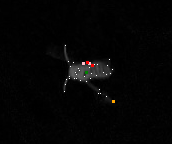

Best tips at: (72, 69) and (80, 67) with score 1.0
Best roots at: (82, 66) and (82, 66) with score 2.37
Best stinger at: (84, 103) with score 2.81


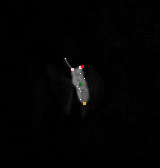

Detected 2 yellowjackets in Image 29
Best tips at: (77, 99) and (52, 69) with score 1.0
Best roots at: (71, 72) and (55, 67) with score 0.82
Best stinger at: (83, 100) with score 2.52


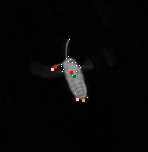

Best tips at: (68, 49) and (56, 54) with score 0.99
Best roots at: (68, 45) and (58, 46) with score 2.32
Best stinger at: (67, 88) with score 2.95


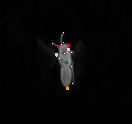

Detected 2 yellowjackets in Image 30
Best tips at: (70, 91) and (79, 88) with score 1.0
Best roots at: (73, 97) and (81, 95) with score 1.95
Best stinger at: (63, 39) with score 2.63


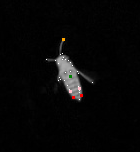

Best tips at: (59, 40) and (49, 26) with score 0.99
Best roots at: (56, 26) and (56, 26) with score 1.98
Best stinger at: (59, 56) with score 2.78


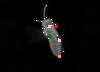

Detected 2 yellowjackets in Image 31
Best tips at: (65, 69) and (60, 72) with score 1.0
Best roots at: (67, 70) and (61, 68) with score 2.02
Best stinger at: (88, 100) with score 2.8


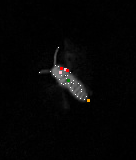

Best tips at: (73, 53) and (61, 56) with score 1.0
Best roots at: (73, 55) and (60, 54) with score 2.46
Best stinger at: (78, 83) with score 1.91


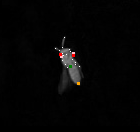

Detected 2 yellowjackets in Image 32
Best tips at: (108, 67) and (109, 79) with score 0.99
Best roots at: (116, 69) and (111, 80) with score 1.93
Best stinger at: (75, 58) with score 2.7


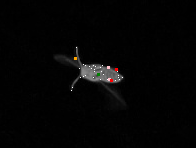

Best tips at: (83, 64) and (74, 60) with score 0.99
Best roots at: (83, 62) and (79, 59) with score 2.12
Best stinger at: (74, 89) with score 2.89


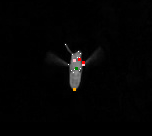

Detected 2 yellowjackets in Image 33
Best tips at: (64, 81) and (64, 67) with score 1.0
Best roots at: (66, 83) and (66, 75) with score 1.4
Best stinger at: (94, 79) with score 2.88


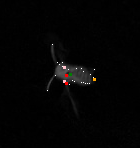

Best tips at: (72, 81) and (81, 78) with score 1.0
Best roots at: (72, 72) and (84, 74) with score 2.13
Best stinger at: (80, 105) with score 2.88


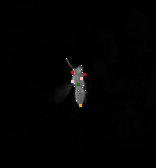

Detected 2 yellowjackets in Image 34
Best tips at: (76, 92) and (80, 92) with score 1.0
Best roots at: (75, 90) and (75, 90) with score 1.54
Best stinger at: (88, 114) with score 2.92


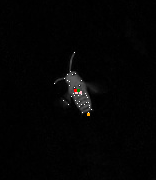

Best tips at: (86, 97) and (83, 88) with score 1.0
Best roots at: (86, 94) and (86, 94) with score 1.0
Best stinger at: (75, 67) with score 2.62


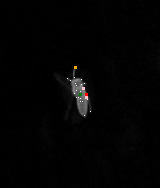

Detected 2 yellowjackets in Image 35
Best tips at: (73, 98) and (78, 103) with score 1.0
Best roots at: (73, 102) and (76, 105) with score 1.99
Best stinger at: (76, 62) with score 2.63


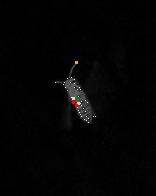

Best tips at: (74, 79) and (67, 86) with score 1.0
Best roots at: (74, 75) and (66, 83) with score 2.24
Best stinger at: (88, 104) with score 2.56


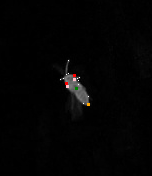

Detected 2 yellowjackets in Image 36
Best tips at: (53, 61) and (59, 61) with score 1.0
Best roots at: (57, 59) and (57, 59) with score 2.01
Best stinger at: (78, 76) with score 2.88


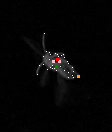

Best tips at: (77, 61) and (72, 62) with score 0.98
Best roots at: (81, 57) and (80, 63) with score 2.24
Best stinger at: (74, 101) with score 2.66


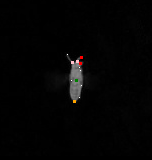

Detected 2 yellowjackets in Image 37
Best tips at: (69, 70) and (72, 67) with score 1.0
Best roots at: (63, 73) and (63, 73) with score 1.73
Best stinger at: (93, 84) with score 2.8


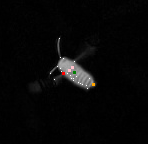

Best tips at: (65, 32) and (56, 30) with score 1.0
Best roots at: (67, 30) and (55, 28) with score 2.42
Best stinger at: (63, 64) with score 2.81


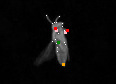

Detected 2 yellowjackets in Image 38
Best tips at: (80, 88) and (88, 83) with score 1.0
Best roots at: (82, 87) and (85, 82) with score 2.67
Best stinger at: (63, 29) with score 2.58


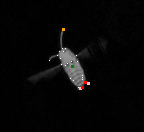

Best tips at: (60, 27) and (49, 30) with score 1.0
Best roots at: (58, 25) and (49, 25) with score 2.42
Best stinger at: (70, 60) with score 2.86


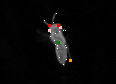

Detected 2 yellowjackets in Image 39
Best tips at: (64, 70) and (68, 66) with score 1.0
Best roots at: (65, 75) and (72, 67) with score 2.32
Best stinger at: (99, 104) with score 2.94


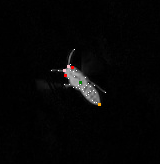

Best tips at: (49, 66) and (53, 59) with score 0.99
Best roots at: (47, 63) and (53, 54) with score 2.04
Best stinger at: (77, 80) with score 2.9


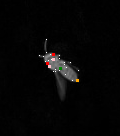

Detected 2 yellowjackets in Image 40
Best tips at: (63, 65) and (71, 73) with score 1.0
Best roots at: (69, 65) and (71, 70) with score 1.25
Best stinger at: (40, 57) with score 2.62


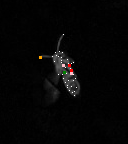

Best tips at: (69, 79) and (67, 83) with score 0.97
Best roots at: (78, 70) and (69, 66) with score 1.79
Best stinger at: (74, 104) with score 1.99


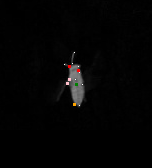

Detected 2 yellowjackets in Image 41
Best tips at: (68, 63) and (69, 76) with score 1.0
Best roots at: (68, 61) and (67, 70) with score 1.41
Best stinger at: (39, 76) with score 2.66


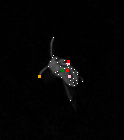

Best tips at: (80, 75) and (72, 75) with score 1.0
Best roots at: (80, 72) and (71, 69) with score 2.34
Best stinger at: (76, 107) with score 2.51


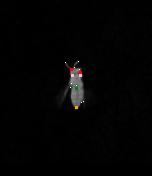

Detected 2 yellowjackets in Image 42
Best tips at: (86, 72) and (84, 70) with score 1.0
Best roots at: (83, 67) and (83, 67) with score 2.5
Best stinger at: (100, 87) with score 2.71


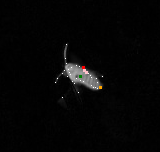

Best tips at: (57, 51) and (65, 47) with score 0.99
Best roots at: (57, 48) and (69, 48) with score 2.48
Best stinger at: (73, 81) with score 2.78


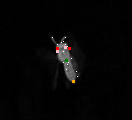

Detected 2 yellowjackets in Image 43
Best tips at: (62, 86) and (72, 92) with score 1.0
Best roots at: (66, 88) and (70, 93) with score 0.87
Best stinger at: (73, 48) with score 2.59


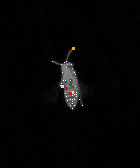

Best tips at: (43, 27) and (37, 25) with score 1.0
Best roots at: (42, 29) and (37, 27) with score 2.35
Best stinger at: (45, 55) with score 2.48


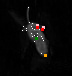

Detected 1 yellowjackets in Image 44
Best tips at: (67, 63) and (63, 65) with score 1.0
Best roots at: (67, 58) and (62, 60) with score 2.25
Best stinger at: (76, 103) with score 2.95


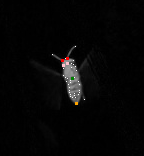

Detected 2 yellowjackets in Image 45
Best tips at: (73, 96) and (82, 93) with score 1.0
Best roots at: (78, 100) and (84, 95) with score 1.35
Best stinger at: (73, 56) with score 2.58


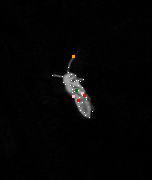

Best tips at: (77, 63) and (84, 80) with score 0.99
Best roots at: (66, 71) and (67, 77) with score 1.72
Best stinger at: (82, 90) with score 1.89


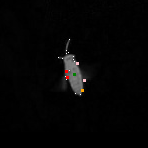

Detected 2 yellowjackets in Image 46
Best tips at: (61, 73) and (56, 78) with score 0.99
Best roots at: (64, 70) and (54, 76) with score 2.49
Best stinger at: (86, 104) with score 2.97


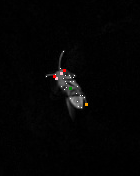

Best tips at: (75, 68) and (69, 69) with score 0.97
Best roots at: (75, 65) and (66, 67) with score 2.47
Best stinger at: (80, 103) with score 2.74


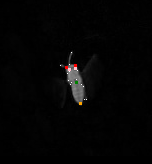

Detected 2 yellowjackets in Image 47
Best tips at: (74, 71) and (63, 81) with score 1.0
Best roots at: (68, 68) and (61, 77) with score 1.89
Best stinger at: (93, 100) with score 2.81


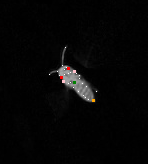

Best tips at: (41, 43) and (54, 34) with score 1.0
Best roots at: (45, 37) and (57, 36) with score 1.89
Best stinger at: (64, 67) with score 2.74


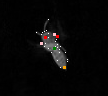

Detected 1 yellowjackets in Image 48
Best tips at: (75, 60) and (65, 59) with score 1.0
Best roots at: (75, 64) and (67, 57) with score 2.35
Best stinger at: (65, 105) with score 2.91


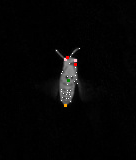

Detected 2 yellowjackets in Image 49
Best tips at: (72, 81) and (67, 76) with score 1.0
Best roots at: (69, 85) and (69, 85) with score 1.18
Best stinger at: (68, 54) with score 2.65


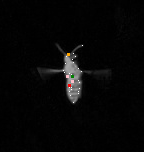

Best tips at: (42, 56) and (48, 49) with score 1.0
Best roots at: (43, 58) and (43, 58) with score 2.28
Best stinger at: (50, 92) with score 2.75


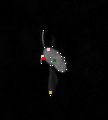

In [8]:
def padZeroes(number, digits):
    return ("{:{}{}}".format(number, 0, digits))

markedUpDict = {}
specialPointsDict = {}
index = 0

for nimage,imagefile in enumerate(imagefiles):

    img = imageio.imread(imagefile)

    # allow for RGB or RGBA image
    if len(img.shape)==3: 
        img = img[:,:,:3].sum(axis=2)/3

    # pre-convolution thresholding
    #above = form > preconvthreshold
    #img[:,:] = 0
    #img[above] = 255
    

    images = detectAndCrop(img, kernel)
    print('Detected', int(len(images)), 'yellowjackets in Image', nimage)
    for i,image in enumerate(images):
        
        markedUpImage, specialPoints = specialCorners(image)
        display(markedUpImage)
        
        newKey = 'yellowjacket_' + padZeroes(index,3)
        specialPointsDict[newKey] = specialPoints
        markedUpDict[newKey] = markedUpImage
        index += 1

        #print('Writing image', nimage,'-',i, 'with dots...')
        #validation = imagePath+'/processed/'+imagefile[18:-4]+'-'+str(i)+'_validation.jpg' #_'+timestamp+'.jpg')
        #markedUpImage.save(validation)

In [9]:
def reshape(img, width, height):
    heightToCrop = np.shape(img)[0] - height
    widthToCrop = np.shape(img)[1] - width
    
    if heightToCrop > 0:
        img = img[int(heightToCrop/2):int(heightToCrop/2)+height,:,:]
    elif heightToCrop < 0:
        blank = np.zeros((height, np.shape(img)[1],np.shape(img)[2]), dtype = np.uint8)
        blank[int(-heightToCrop/2):int(-heightToCrop/2)+np.shape(img)[0],:,:] = img
        img = blank
        
    if widthToCrop > 0:
        img = img[:,int(widthToCrop/2):int(widthToCrop/2)+width,:]
    elif widthToCrop < 0:
        blank = np.zeros((np.shape(img)[0], width, np.shape(img)[2]), dtype = np.uint8)
        blank[:,int(-widthToCrop/2):int(-widthToCrop/2)++np.shape(img)[1],:] = img
        img = blank
    
    return(img)

In [10]:
def createJson(specialPointsDict):
    with open(savePath+'/json_output.json', 'w') as outfile:
        json.dump(specialPointsDict, outfile, indent=3)

## SAVE BEFORE RUNNING THIS CELL

Writing image 1 of 73 ...


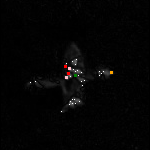

Writing image 2 of 73 ...


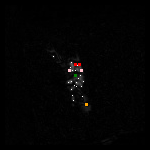

Writing image 3 of 73 ...


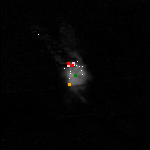

Writing image 4 of 73 ...


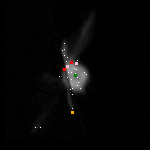

Writing image 5 of 73 ...


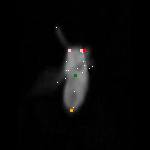

Writing image 6 of 73 ...


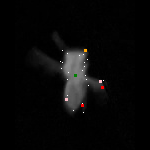

Writing image 7 of 73 ...


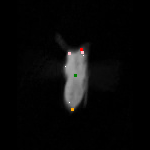

Writing image 8 of 73 ...


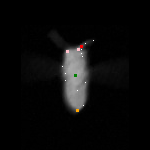

Writing image 9 of 73 ...


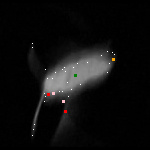

Writing image 10 of 73 ...


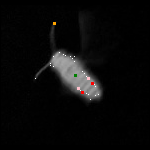

Writing image 11 of 73 ...


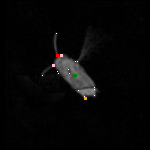

Writing image 12 of 73 ...


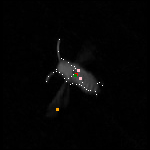

Writing image 13 of 73 ...


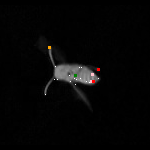

Writing image 14 of 73 ...


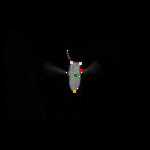

Writing image 15 of 73 ...


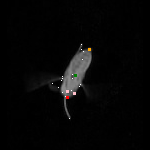

Writing image 16 of 73 ...


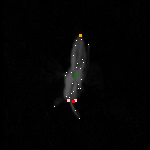

Writing image 17 of 73 ...


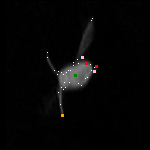

Writing image 18 of 73 ...


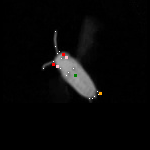

Writing image 19 of 73 ...


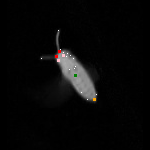

Writing image 20 of 73 ...


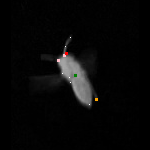

Writing image 21 of 73 ...


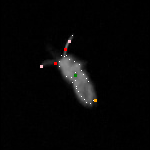

Writing image 22 of 73 ...


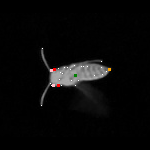

Writing image 23 of 73 ...


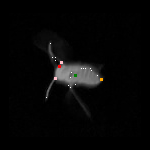

Writing image 24 of 73 ...


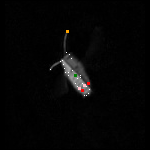

Writing image 25 of 73 ...


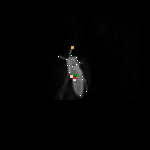

Writing image 26 of 73 ...


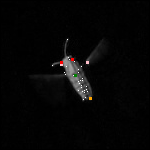

Writing image 27 of 73 ...


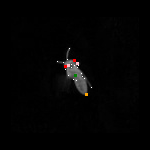

Writing image 28 of 73 ...


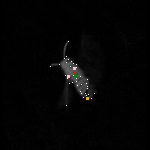

Writing image 29 of 73 ...


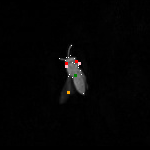

Writing image 30 of 73 ...


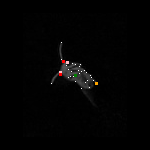

Writing image 31 of 73 ...


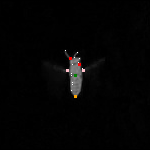

Writing image 32 of 73 ...


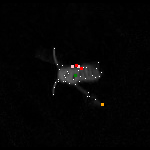

Writing image 33 of 73 ...


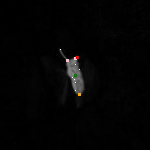

Writing image 34 of 73 ...


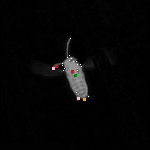

Writing image 35 of 73 ...


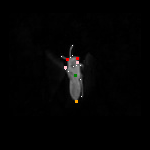

Writing image 36 of 73 ...


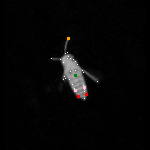

Writing image 37 of 73 ...


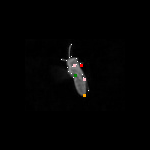

Writing image 38 of 73 ...


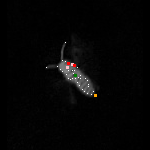

Writing image 39 of 73 ...


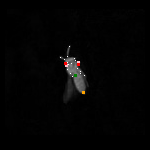

Writing image 40 of 73 ...


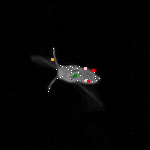

Writing image 41 of 73 ...


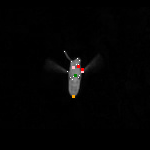

Writing image 42 of 73 ...


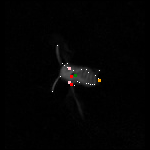

Writing image 43 of 73 ...


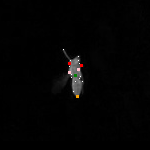

Writing image 44 of 73 ...


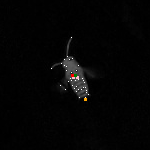

Writing image 45 of 73 ...


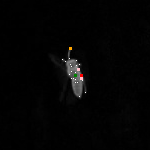

Writing image 46 of 73 ...


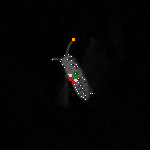

Writing image 47 of 73 ...


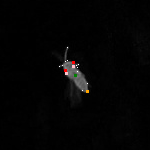

Writing image 48 of 73 ...


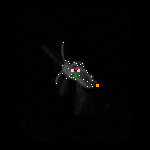

Writing image 49 of 73 ...


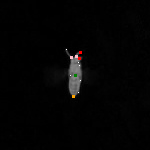

Writing image 50 of 73 ...


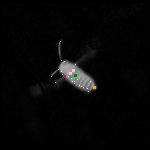

Writing image 51 of 73 ...


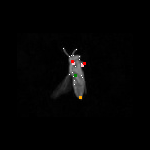

Writing image 52 of 73 ...


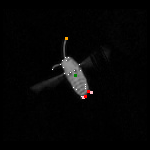

Writing image 53 of 73 ...


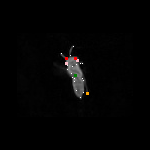

Writing image 54 of 73 ...


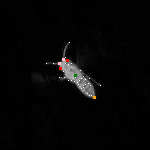

Writing image 55 of 73 ...


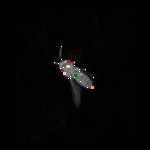

Writing image 56 of 73 ...


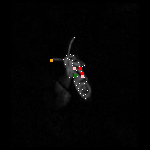

Writing image 57 of 73 ...


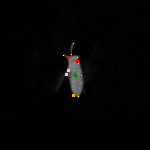

Writing image 58 of 73 ...


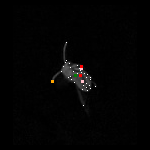

Writing image 59 of 73 ...


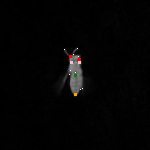

Writing image 60 of 73 ...


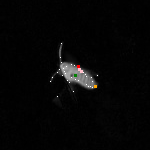

Writing image 61 of 73 ...


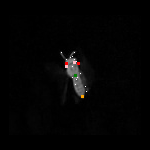

Writing image 62 of 73 ...


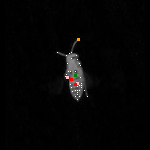

Writing image 63 of 73 ...


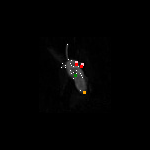

Writing image 64 of 73 ...


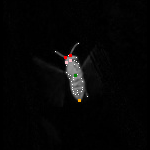

Writing image 65 of 73 ...


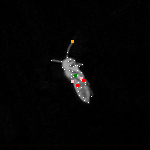

Writing image 66 of 73 ...


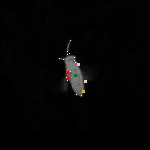

Writing image 67 of 73 ...


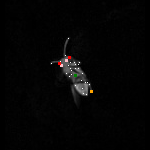

Writing image 68 of 73 ...


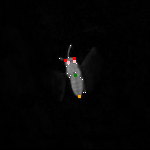

Writing image 69 of 73 ...


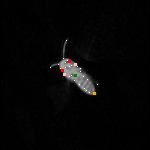

Writing image 70 of 73 ...


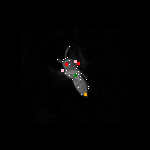

Writing image 71 of 73 ...


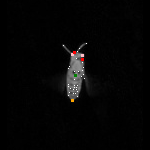

Writing image 72 of 73 ...


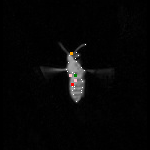

Writing image 73 of 73 ...


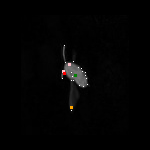

In [11]:
width, height = 150, 150  # pixel dimensions for output

if not os.path.exists(savePath):
    os.makedirs(savePath)
    
for i,key in enumerate(markedUpDict.keys()):
    image = markedUpDict[key]
    imgArray = np.array(image)
    imgArray = reshape(imgArray,150,150)
    image = Image.fromarray(imgArray)
    print('Writing image', i+1, 'of', len(markedUpDict),'...')
    display(image)
    validation = savePath+'/yellowjacket_' + padZeroes(i,3) + '.png' #_'+timestamp+'.jpg')
    image.save(validation, quality=95)

# Write a copy of the code to the save folder
copyfile('corner_detection.ipynb', savePath+'/corner_detection.ipynb')
# Write a JSON containing the important points
createJson(specialPointsDict)